In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split


In [2]:
# Load data
data_path = Path("C:\\Users\\welde\\Desktop\\Oslomet\\ACIT4610---Final-Group-Project\\R_f\\Project_4\\data\\SMSSpamCollection")
print(f"File exists: {data_path.exists()}")


df = pd.read_csv(
    data_path, 
    sep='\t',              # Tab-separated
    header=None,           # No header row
    names=['label', 'message'],  # Column names
    encoding='utf-8'       # UTF-8 encoding
)

print(f"Loaded {len(df)} messages")
df.head()

File exists: True
Loaded 5572 messages


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Missing values in each column:
label      0
message    0
dtype: int64


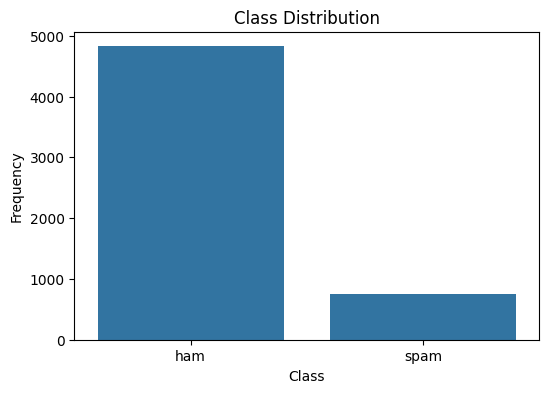

Number of duplicate rows: 403
Number of duplicate rows by label:
label
ham     309
spam     94
dtype: int64
Message length statistics:
count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: message_length, dtype: float64


C:\Users\welde\AppData\Local\Temp\ipykernel_34104\442476248.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  duplicate_by_label = df.groupby('label').apply(lambda x: x.duplicated().sum())


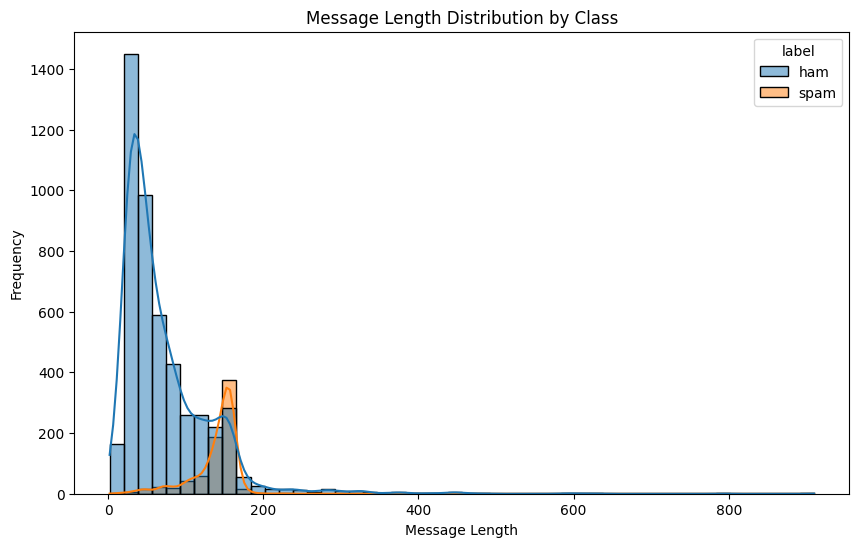

In [3]:
#Explore data
# check for missing values
missing_values = df.isnull().sum()
print("Missing values in each column:")
print(missing_values)

# Check class distribution
class_counts = df['label'].value_counts()
#print("Class distribution:")
#print(class_counts)

# Visualize class distribution
plt.figure(figsize=(6,4))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

# check for duplicates
duplicate_count = df.duplicated().sum()
print("Number of duplicate rows:", duplicate_count)

# check duplicates by label
duplicate_by_label = df.groupby('label').apply(lambda x: x.duplicated().sum())
print("Number of duplicate rows by label:")
print(duplicate_by_label)

# Analyze message lengths
df['message_length'] = df['message'].apply(len)     
print("Message length statistics:")
print(df['message_length'].describe())  

# Visualize message length distribution
plt.figure(figsize=(10,6))  
sns.histplot(data=df, x='message_length', hue='label', bins=50, kde=True)
plt.title("Message Length Distribution by Class")
plt.xlabel("Message Length")        
plt.ylabel("Frequency")
plt.show()



In [4]:
'''preprocess data'''
df_cleaned = df.copy()
df_cleaned = df_cleaned.drop_duplicates()  # Remove duplicates
# check for duplicates
duplicate_count = df_cleaned.duplicated().sum()
print("Number of duplicate rows:", duplicate_count)


df_cleaned['message'] = df_cleaned['message'].str.lower()  # Lowercase
df_cleaned['message'] = df_cleaned['message'].apply(lambda x: re.sub(r'[^a-z0-9\s]', '', x))  # Remove punctuation
df_cleaned['message'] = df_cleaned['message'].apply(lambda x: re.sub(r'\s+', ' ', x).strip())  # Remove extra whitespace

df_cleaned['cleaned_length'] = df_cleaned['message'].apply(len)  # Length of cleaned message
#df_cleaned.head()

# tokenization
df_cleaned['tokens'] = df_cleaned['message'].apply(lambda x: x.split())

#limitization
ps = PorterStemmer()
df_cleaned['lemmatized_tokens'] = df_cleaned['tokens'].apply(lambda tokens: [ps.stem(token) for token in tokens])  # Apply stemming


df_cleaned = df_cleaned.drop(columns=['tokens'])

df_cleaned['cleaned_length'] = df_cleaned['lemmatized_tokens'].apply(len) 






Number of duplicate rows: 0


# We noticed that there are to aplicable types of feature extractions in this case
- BoW (bag of words) which is numeric representation of text were a text is a vector of word counts
- TF-IDF (term frequency- Inverse Document Frequency) similiar to BoW but it gives lower weight to common words and higher weight to distinctive ones

we decided to check both of them and take the best one

In [5]:
# feature extraction 

#BoW

bow_vectorizer = CountVectorizer(analyzer=lambda x: x)  # Use the tokens directly
X_bow = bow_vectorizer.fit_transform(df_cleaned['lemmatized_tokens'])


# TF-IDF
tfidf_vectorizer = TfidfVectorizer(analyzer=lambda x: x)  # Use the tokens directly
X_tfidf = tfidf_vectorizer.fit_transform(df_cleaned['lemmatized_tokens'])




In [ ]:
# train test split
ham_data = df_cleaned[df_cleaned['label'] == 'ham'] # self data
spam_data = df_cleaned[df_cleaned['label'] == 'spam'] # non-self data

ham_train, ham_test = train_test_split(ham_data, test_size=0.2, random_state=42)

test_data = pd.concat([ham_test, spam_data]).sample(frac=1, random_state=42).reset_index(drop=True)




